In [1]:
import sys
sys.path.insert(1, '../')

from river import stream,tree,metrics
from encoding import prefix_bin
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import os,json
import datetime
from collections import deque, Counter
from sklearn.model_selection import train_test_split
import pandas as pd

import warnings

warnings.filterwarnings("ignore")

import datetime, time
import utils
import sliding_window
import psutil

import copy
import gzip
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

In [2]:
#torch cuda setting
with torch.no_grad():
    torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [3]:
def display_progress(row_counting, total_length, interval=10000):
    if rowcounter%interval == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running cases: %s'%(len(streaming_db)))

In [4]:
class Customdataset():
    def __init__(self, cdataset):
        '''
        Convert dataset to tensor
        
        Params
        dataset_type: Type of dataset, trainset, validset, and testset
        '''
        self.cdataset = cdataset


    def preprocessing(self):
        self.x_data=self.cdataset[0]
        self.y_data=self.cdataset[1]

        x = self.x_data.to_numpy()
        x = np.reshape(x, (x.shape[0],1, x.shape[1]))
        y_set = sorted(set(self.y_data))
        train_y =[]
        for y in self.y_data:
            train_y.append(y_set.index(y))

        x_tensor = torch.tensor(x, dtype=torch.float)
        y_tensor = torch.tensor(train_y, dtype=torch.long)

        return x_tensor, y_tensor

    
    def test_preprocessing(self):
        self.x_data=self.cdataset

        x = self.x_data.to_numpy()
        x = np.reshape(x, (x.shape[0],1, x.shape[1]))

        x_tensor = torch.tensor(x, dtype=torch.float)

        return x_tensor
      

In [5]:
class LSTM_model(nn.Module): # nn.Module inherit

    def __init__(self, input_x, raw_y):
        super(LSTM_model, self).__init__()
        
        self.input_size = input_x.shape[2]
        self.hidden_size =2* input_x.shape[2]
        self.num_case = 1
        self.num_layers =2

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers, dropout=0.25, batch_first =False, bidirectional = False)

        self.h0 = torch.randn(self.num_layers, 1, self.hidden_size, device=device)
        self.c0 = torch.randn(self.num_layers, 1, self.hidden_size, device=device)

        latent_vector_size =30 * 1
        self.linear1 = nn.Linear(1 *self.num_case *self.hidden_size, latent_vector_size)
        self.linear_h = nn.Linear(1 *self.num_layers *self.hidden_size, latent_vector_size)
        self.linear_o = nn.Linear(3 * latent_vector_size, 1 *self.num_case * len(set(raw_y)))

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, input_x):
        output, (hn,cn) = self.lstm(input_x, (self.h0,self.c0))
        output = output.reshape((output.size()[0] *output.size()[1] *output.size()[2]))
        output = self.relu(self.linear1(output))

        uH = F.leaky_relu(self.linear_h(hn.reshape((hn.size()[0] *hn.size()[1] *hn.size()[2]))))
        uC = F.leaky_relu(self.linear_h(cn.reshape((cn.size()[0] *cn.size()[1] *cn.size()[2]))))
        output = torch.cat((uH ,uC ,output))
        output = self.sigmoid(self.linear_o(output))
        output =output.reshape(self.num_case,-1)

        return output

In [6]:
def training_stage(datafortraining):
    '''
    Manage training stage of streaming anomaly detection
    ----------
    Parameters
    window: class training_window
        Sliding window with training data
    training_models: dict
        Trained detector by prefix stored in. Default is randomforest
    ----------
    Return
    training_models
    '''
    cross_entropy_loss = torch.nn.CrossEntropyLoss()

    train_x,train_y = Customdataset(datafortraining).preprocessing()
    loss_list =[]

    x_tensor = torch.unsqueeze(train_x[0], dim=0)
    y_tensor = torch.unsqueeze(train_y[0], dim=0)
    model = LSTM_model(x_tensor, y_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    optimizer.zero_grad()
    loss = nn.BCELoss ()
    losses = []

    previous_model =0
    for i in range(30):
        running_loss =0
        for pos, x2 in enumerate(train_x):
            x_tensor = torch.unsqueeze(x2, dim=0)
            y_tensor = torch.tensor([[float(train_y[pos])]])

            output = model(x_tensor)
#             running_loss += loss.item()
            l = loss(output, y_tensor)
            running_loss +=l.item()

            l.backward()
            optimizer.step()
        loss_list.append(running_loss)
        previous_model = model
        epoch_loss = running_loss / len(train_x)
        losses.append(epoch_loss)

        if len(loss_list) ==0:
            pass

        else:
            if epoch_loss > np.mean(losses):
                break

    return model

In [7]:
def first_event(case_bin):
    '''
    Generate start event before first event
    '''
    print(case_bin.event['ts'])
    empty_data ={'activity':'Start signal', 'ts':datetime.datetime.strftime(case_bin.event['ts'], '%Y-%m-%d %H:%M:%S')}
    start_event = prefix_bin(case_bin.caseid, empty_data)
    start_event.set_prefix_length(0)
    start_event.update_encoded(catattrs=catatars,enctype=enctype)
    start_event.update_truelabel(case_bin.event['activity'])
    return start_event

In [8]:
def update_test_cases(new_case, test_cases):
    test_cases.append(new_case)
    if len(test_cases) > test_size:
        test_cases.popleft()

In [9]:
def predict_proba(model, test_x):
    
    with torch.no_grad():
        test_output = model(test_x)
        test_output = test_output.detach().reshape(-1).numpy()[0]
        y_pred = [[1-test_output, test_output]]
    return y_pred

In [10]:
training_time = []

In [13]:
# for dataset_label in ['bpic2012_1','bpic2012_2','bpic2012_3','bpic2017_1','bpic2017_2','bpic2017_3','IRO5K' ,'OIR5K']:
for dataset_label in ['bpic2011_1','bpic2011_3','bpic2011_4','bpic2015_1','bpic2015_2','bpic2015_3','bpic2015_4','bpic2015_5',
                      'Production_Data','sepsis_cases_1','sepsis_cases_2','sepsis_cases_3','traffic_fines_1','hospital_billing_1',
                      'hospital_billing_2']:
  
    # Experiment settings
    print(dataset_label)
    classifier = 'lstm'
    # Invoke parameters for dataset
    window_size = 200
    test_size = 30
    gp = 200
    training_rebalance = True
    retraining_condition = 'variant'
    retraining_check = True

    with open('../dataset_parameters.json','r') as json_file:
        parameters = json.load(json_file)[dataset_label]
        print(parameters)
        key_pair = parameters['key_pair']
        catatars = parameters['categorical_attrs']
        maximum_prefixs = parameters['maximum_prefix']
        prefix_range = parameters['prefix']
        
    for maximum_prefix in prefix_range:
        start_time = time.time()
        print(maximum_prefix)
        train_window_dict = {}
        test_window_dict = {}
        dataset_loc = '../DATA/logs/'+ dataset_label +'.csv'
        try:
            os.makedirs('../result/%s'%(dataset_label))
        except:
            pass
        dataset = stream.iter_csv(
                dataset_loc
                )
        totallength = len(list(dataset))

        dataset = stream.iter_csv(
                dataset_loc,
                # drop=['Complete Timestamp'],
                target='outcome'
                )
        enctype = 'Index-base'

        streaming_db ={}
        training_windows = sliding_window.training_window(window_size,test_size)
        training_models ={}
        test_cases = deque()
        feature_matrix ={}

        save_model = {}
        casecount = 0
        rowcounter = 0
        finished_db ={}
        running_case = 0
        window_acc_dict = {}
        prediction_result = dict()
        for i in range(1, maximum_prefix+1): prediction_result[i] = {}
        finished_caseid = set()
        usedingrace = set()

        for x,y in dataset:
    #         display_progress(rowcounter, totallength)
            rowcounter +=1
            # Event stream change dictionary keys
            x = utils.dictkey_chg(x, key_pair)

#             if dataset_label !='bpic15':
#                  x['ts'] = x['ts'][:-4]

            x['outcome'] =y 
            # Initialize case by prefix length        
            caseid = x['caseid']
            outcome = x['outcome']
        #     progress = x['progress']

            x.pop('caseid')
            x.pop('outcome')

        #     x.pop('progress')

            case_bin = prefix_bin(caseid, x)
            case_bin.set_enctype(enctype)

            if caseid not in list(streaming_db.keys()):
                case_bin.set_prefix_length(1)    
                streaming_db[caseid] = []
            elif caseid in finished_caseid:
                pass
            else:
                case_bin.set_prefix_length(len(streaming_db[caseid])+1)
                case_bin.set_prev_enc(streaming_db[caseid][-1])

            # Encode event and cases and add to DB
            case_bin.update_truelabel(outcome)   
            case_bin.update_encoded(catattrs=catatars,enctype=enctype)
            ts = case_bin.event['ts']
            streaming_db[caseid].append(case_bin)

            # Set current activity as outcome of previous event
            if case_bin.prefix_length != 1 and case_bin.caseid not in finished_caseid:
                case_bin.prev_enc.update_truelabel(x['activity'])

            # First prediction for current event

            last_event = case_bin
            modelid = 'None'
            prediction = 'Not Available'

            # Detect label appeared case 
            if outcome != '' and caseid not in finished_caseid:
                usedingrace.add(caseid)
                for i in streaming_db[caseid]:
                    i.update_truelabel(outcome)
                finished_caseid.add(caseid)
                # Adding newly finished case to training set.    
                casecount +=1
                # Grace period to collect feature matrix
                if casecount < gp:
                    case_length = len(streaming_db[caseid])
                    if case_length >= maximum_prefix:
                        if 'prefix_%s'%(maximum_prefix) not in list(feature_matrix.keys()):
                            feature_matrix['prefix_%s'%(maximum_prefix)]=set()
                            training_models['prefix_%s'%(maximum_prefix)] = [0,
                                                                       0]
                        feature_list = list(streaming_db[caseid][maximum_prefix-1].encoded.keys())
                        for x in feature_list: feature_matrix['prefix_%s'%(maximum_prefix)].add(x) 
                else:
                    break

        if casecount not in train_window_dict.keys(): train_window_dict[casecount] = []
        if casecount not in test_window_dict.keys(): test_window_dict[casecount] = []

        for caseid in list(usedingrace):
            case_length = len(streaming_db[caseid])
            if case_length >= maximum_prefix:
                x = streaming_db[caseid][maximum_prefix-1]
                if x.prefix_length != 0:            
                    training_windows.update_window(x)        

                update_test_cases(streaming_db[caseid], test_cases)
        train_window_dict[casecount].append(copy.deepcopy(training_windows.container))

    #     x_prefix_length = 0
        training_x = []
        training_y = []
        for pos, i in enumerate(training_windows.container):
            x_prefix_length = i.prefix_length 
            i.encoded = utils.readjustment_training(i.encoded, feature_matrix['prefix_%s'%(maximum_prefix)])
            training_x.append(i.encoded)
            training_y.append(i.true_label)

        le = LabelEncoder()
        training_y = le.fit_transform(training_y)
        training_x = pd.DataFrame.from_dict(training_x)

        ###
        #Oversampling
        ###
        n_labels = Counter(training_y)['True']
        if n_labels <=2:
            pass
        elif n_labels>2 and n_labels <=5:
            smote = SMOTE(k_neighbors=n_labels-1)
            training_x, training_y = smote.fit_resample(training_x, training_y)
        else:
            smote = SMOTE()
            training_x, training_y = smote.fit_resample(training_x, training_y)

        training_models['prefix_%s'%(x_prefix_length)][0] = training_stage((training_x, training_y))
        training_models['prefix_%s'%(x_prefix_length)][1] = casecount

        prediction_result[maximum_prefix][casecount] = {}
        y_truelist = []
        y_predlist = []
        for case in test_cases:
            if len(case) >= maximum_prefix:
                x = case[maximum_prefix-1]
                if x.prefix_length != 0:            
                    model = training_models['prefix_%s'%(x_prefix_length)][0]
                    current_event = utils.readjustment_training(x.encoded, feature_matrix['prefix_%s'%(maximum_prefix)])
                    current_event = pd.Series(current_event).to_frame().T
                    current_event = Customdataset(current_event).test_preprocessing()
                    y_pred = predict_proba(model, current_event)            
                    y_truelist.append(x.true_label)
                    y_predlist.append(y_pred)
                    test_window_dict[casecount].append(x)

        prediction_result[maximum_prefix][casecount]['y_true'] = y_truelist
        prediction_result[maximum_prefix][casecount]['y_pred'] = y_predlist


        '''
        Streaming event label prediction start.
        - Test and training steps are executed when case finished/ event arrived with label
        '''
        for i in streaming_db.keys(): usedingrace.add(i)
        streaming_db ={}
        cdhappend ={}
        for i in range(1, maximum_prefix+1): cdhappend[i] = 0

        ## Start streaming again
        for x,y in dataset:
            display_progress(rowcounter, totallength)

            rowcounter +=1
            # Event stream change dictionary keys
            x = utils.dictkey_chg(x, key_pair)

#             if dataset_label !='bpic15':
#                 x['ts'] = x['ts'][:-4]

            # Check label possible
            # x = utils.set_label(x)
            x['outcome'] =y 
            # Initialize case by prefix length
            caseid = x['caseid']
            outcome = x['outcome']
            x.pop('caseid')
            x.pop('outcome')

            if caseid not in usedingrace:
                case_bin = prefix_bin(caseid, x)
                case_bin.set_enctype(enctype)

                if caseid not in list(streaming_db.keys()):
                    case_bin.set_prefix_length(1)    
                    streaming_db[caseid] = []
                    running_case +=1
                elif caseid in finished_caseid:
                    pass
                else:
                    case_bin.set_prefix_length(len(streaming_db[caseid])+1)
                    case_bin.set_prev_enc(streaming_db[caseid][-1])

                # Encode event and cases and add to DB
                case_bin.update_truelabel(outcome)   
                case_bin.update_encoded(catattrs=catatars,enctype=enctype)
                ts = case_bin.event['ts']

                if case_bin.prefix_length == maximum_prefix:
                    case_bin.encoded = utils.readjustment_training(case_bin.encoded, feature_matrix['prefix_%s'%(case_bin.prefix_length)])
                streaming_db[caseid].append(case_bin)

                # Detect label appeared case 
                if outcome != '' and caseid not in finished_caseid:
                    finished_caseid.add(caseid)

                    # Adding newly finished case to training set.
                    casecount +=1    

                    # Modify encoded attributes of cases with feature matrix
                    case_length = len(streaming_db[caseid])
                    if case_length >= maximum_prefix:

                        update_test_cases(streaming_db[caseid], test_cases)
                        streaming_db[caseid][maximum_prefix-1].update_truelabel(outcome)
                        x = streaming_db[caseid][maximum_prefix-1].encoded
                        prefix_length =streaming_db[caseid][maximum_prefix-1].prefix_length                    
    #                     save_model['%s_%s'%(prefix_length, model_update_count)] = training_models['prefix_%s'%(streaming_db[caseid][maximum_prefix-1].prefix_length)][0]
                    y_truelist = []
                    y_predlist = []
                    if casecount ==200:
                        break
                    if casecount not in test_window_dict.keys():
                        test_window_dict[casecount] = []

                    for case in test_cases:
                        if len(case) >= maximum_prefix:
                            x = case[maximum_prefix-1]
                            if x.prefix_length != 0:
                                length = x.prefix_length
                                current_event = utils.readjustment_training(x.encoded, feature_matrix['prefix_%s'%(maximum_prefix)])
                                current_event = pd.Series(current_event).to_frame().T
                                current_event = Customdataset(current_event).test_preprocessing()
                                with torch.no_grad():
                #                     label_classes = training_models['detector_window_%s'%(last_event.prefix_length)][2]
                                    test_output = model(current_event)
                                    test_output = test_output.detach().reshape(-1).numpy()[0]
                                    y_pred = [[1-test_output, test_output]]

                                y_truelist.append(x.true_label)
                                y_predlist.append(y_pred)
                                test_window_dict[casecount].append(x)
                                if casecount != gp:
                                    c_id = [x.caseid for x in test_window_dict[casecount-1]]

                                if x.caseid not in c_id:
                                    model = training_models['prefix_%s'%(x_prefix_length)][0]
                                    y_pred = predict_proba(model, current_event)
                                else:
                                    y_pred = prediction_result[maximum_prefix][casecount-1]['y_pred'][c_id.index(x.caseid)]
                                y_truelist.append(x.true_label)
                                y_predlist.append(y_pred)

                                if casecount not in test_window_dict.keys():
                                    test_window_dict[casecount] = []
                                test_window_dict[casecount].append(x)
                    prediction_result[maximum_prefix][casecount] = {}
                    prediction_result[maximum_prefix][casecount]['y_true'] = y_truelist
                    prediction_result[maximum_prefix][casecount]['y_pred'] = y_predlist
    #                 if 'b1' not in caseid and cdhappend[maximum_prefix] == 0:
    #                     cdhappend[maximum_prefix] = model_update_count

        try:
            os.makedirs('../result/%s/%s/Finished cases/Train once'%(dataset_label, classifier))
        except:
            pass

        with gzip.open('../result/%s/%s/Finished cases/Train once/prefix_%s training window.pkl'%(dataset_label, classifier, maximum_prefix), 'wb') as f:
            pkl.dump(train_window_dict, f)
        with gzip.open('../result/%s/%s/Finished cases/Train once/prefix_%s test window.pkl'%(dataset_label, classifier, maximum_prefix), 'wb') as f:
            pkl.dump(test_window_dict, f)
        with gzip.open('../result/%s/%s/Finished cases/Train once/prefix_%s update.pkl'%(dataset_label, classifier, maximum_prefix), 'wb') as f:
            pkl.dump(prediction_result, f)

        model_path = '../result/%s/%s/Finished cases/Train once/prefix_%s model.pth'%(dataset_label, classifier, maximum_prefix)
        model = training_models['prefix_%s'%(x_prefix_length)][0]
        torch.save(model.state_dict(), model_path)
        del model

bpic2011_1
{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Complete Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 40, 'prefix': [10, 19, 27]}
10
26.62 % Case finished: 227 Running cases: 59
33.27 % Case finished: 257 Running cases: 151
39.92 % Case finished: 301 Running cases: 223
46.58 % Case finished: 358 Running cases: 286
53.23 % Case finished: 394 Running cases: 325
59.88 % Case finished: 438 Running cases: 370
66.54 % Case finished: 483 Running cases: 410
73.19 % Case finished: 545 Running cases: 455
79.85 % Case finished: 581 Running cases: 501
86.5 % Case finished: 612 Running cases: 535
93.15 % Case finished: 683 Running cases: 580
99.81 % Case finished: 817 Running cases: 629
19
26.62 % Case finished: 227 Running cases: 59
33.27 % Case finished: 257 Running cases: 151
39.92 % Case finished: 301 Running cases: 223
46.58 % Case finished: 358 Running cases: 286
53.23 % Case finished: 394 Running cases: 325

63.43 % Case finished: 554 Running cases: 427
84.58 % Case finished: 742 Running cases: 607
21
42.29 % Case finished: 378 Running cases: 227
63.43 % Case finished: 554 Running cases: 427
84.58 % Case finished: 742 Running cases: 607
30
42.29 % Case finished: 378 Running cases: 227
63.43 % Case finished: 554 Running cases: 427
84.58 % Case finished: 742 Running cases: 607
bpic2015_5
{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Complete Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 40, 'prefix': [11, 21, 30]}
11
33.85 % Case finished: 312 Running cases: 167
50.78 % Case finished: 510 Running cases: 350
67.7 % Case finished: 685 Running cases: 514
84.63 % Case finished: 854 Running cases: 703
21
33.85 % Case finished: 312 Running cases: 167
50.78 % Case finished: 510 Running cases: 350
67.7 % Case finished: 685 Running cases: 514
84.63 % Case finished: 854 Running cases: 703
30
33.85 % Case finished: 312 Running 

In [19]:
training_y

array([], dtype=int64)

In [50]:
finished_caseid

set()

In [52]:
streaming_db

{'0': [<encoding.prefix_bin at 0x1cc2b8f9ca0>]}

In [42]:
case_bin.__dict__

{'prefix_length': 1,
 'caseid': '0',
 'event': {'activity': '1e consult poliklinisch',
  'resource': 'Radiotherapy',
  'ts': datetime.datetime(2005, 1, 3, 0, 0)},
 'enctype': 'Index-base',
 'start_ts': datetime.datetime(2005, 1, 3, 0, 0),
 'prev_enc': None,
 'encoded': {'duration_1': 0,
  'cumduration_1': 0,
  'activity_1 1e consult poliklinisch': 1,
  'resource_1 Radiotherapy': 1},
 'predicted': {},
 'true_label': '',
 'grace_updated': False}

In [235]:
for pos, i in enumerate(training_windows.container):
    print(i.encoded)
    x_prefix_length = i.prefix_length 
    i.encoded = utils.readjustment_training(i.encoded, feature_matrix['prefix_%s'%(maximum_prefix)])
    training_x.append(i.encoded)
    training_y.append(i.true_label)

{'resource_1 112.0': 1, 'cumduration_1': 0, 'activity_1 A_SUBMITTED-COMPLETE': 1, 'duration_1': 0}


TypeError: Can only append a dict if ignore_index=True

In [357]:
x_tensor = torch.unsqueeze(train_x[0], dim=0)
y_tensor = torch.unsqueeze(train_y[0], dim=0)
model = LSTM_model(x_tensor, input_y)
optimizer = optim.Adam(model.parameters(), lr=0.0003)
optimizer.zero_grad()
loss = nn.BCELoss ()
losses = []
previous_model =0
for i in range(30):
    running_loss =0
    for pos, x2 in enumerate(train_x):
        x_tensor = torch.unsqueeze(x2, dim=0)
        y_tensor = torch.tensor([[float(train_y[pos])]])
#         y_tensor = torch.unsqueeze(train_y[pos], dim=0)

        output = model(x_tensor)
        l = loss(output, y_tensor)
        running_loss +=l.item()
        l.backward()
        optimizer.step()
        
    loss_list.append(running_loss)
    previous_model = model
    epoch_loss = running_loss / len(train_x)
    losses.append(epoch_loss)
    
    if len(loss_list) ==0:
        pass

    else:
        if epoch_loss > np.mean(losses):
            break

if 'detector_%s'%(x) not in training_models:
    training_models['detector_%s'%(x)] =[0,0,0]
training_models['detector_%s'%(x)][0] += 1
training_models['detector_%s'%(x)][1] = previous_model
training_models['detector_%s'%(x)][2] = sorted(set(input_y))

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

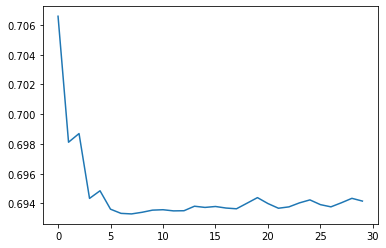

In [358]:
plt.plot(losses)